## Setup

In [53]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
fig_width = (21-5)/2.54
import seaborn as sns
sns.set_context("paper")

import poissonlearning as pl

import storage
import plotting

plotting.setup(latex=True)

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
SAVE_PLOTS = True
NUM_PLOTTING_POINTS = 5000

### Convenience functions

In [55]:
def compute_analytic_solution(xy, z1, z2):
    # Compute the analytic continuum limit
    green_first_label = pl.datasets.one_circle.greens_function(x=xy, z=z1)
    green_second_label = pl.datasets.one_circle.greens_function(x=xy, z=z2)
    solution_analytic = -0.5 * green_first_label + 0.5 * green_second_label
    return solution_analytic


def compute_errors(experiments):
    for experiment in experiments:
        solution = experiment["solution"]
        xy = solution[["x", "y"]].to_numpy()
        z = solution["z"].to_numpy()

        z1 = experiment["label_locations"][0]
        z2 = experiment["label_locations"][1]
        analytic = compute_analytic_solution(xy, z1, z2)

        mask_infty = np.isfinite(analytic)

        # For knn graphs compute the scale
        if "n_neighbors" in experiment:
            knn_scale = np.median((analytic[mask_infty] / z[mask_infty]))
            z *= knn_scale
            experiment["knn_scale"] = knn_scale
            print(f"n={experiment['n']}; n_neighbors={experiment['n_neighbors']} scale={knn_scale}")

        error_L1 = np.abs(z[mask_infty] - analytic[mask_infty]).mean()
        experiment["error_L1"] = error_L1

        # Compute error to dirac experiment, if exists
        e_dirac = list(
            filter(
                lambda x: x["seed"] == experiment["seed"]
                and x["n"] == experiment["n"]
                and ((
                        "eps" in experiment
                        and "eps" in x
                        and np.isclose(x["eps"], experiment["eps"])
                    ) 
                    or (
                        "n_neighbors" in experiment
                        and "n_neighbors" in x
                        and x["n_neighbors"] == experiment["n_neighbors"]
                    )
                )
                and np.allclose(x["label_locations"], experiment["label_locations"])
                and x["kernel"] == experiment["kernel"]
                and x["bump"] == "dirac",
                experiments,
            )
        )
        if e_dirac:
            error_L1_dirac = np.abs(solution["z"] - e_dirac[0]["solution"]["z"]).mean()
            experiment["error_L1_dirac"] = error_L1_dirac

### Load experiments and compute errors

In [56]:
experiments = storage.load_results(name="one_circle_joined", folder="../results")
compute_errors(experiments)

n=10000; n_neighbors=27 scale=2.6025080452006133
n=10000; n_neighbors=27 scale=2.600854154729152
n=10000; n_neighbors=27 scale=2.6025080452006133
n=10000; n_neighbors=27 scale=2.6052836527153924
n=30000; n_neighbors=33 scale=4.063448281421347
n=30000; n_neighbors=33 scale=4.058261640347276
n=30000; n_neighbors=33 scale=4.060988532651576
n=30000; n_neighbors=33 scale=4.066979050388181
n=50000; n_neighbors=35 scale=4.609121394715809
n=50000; n_neighbors=35 scale=4.607116888210167
n=50000; n_neighbors=35 scale=4.608964586569925
n=50000; n_neighbors=35 scale=4.622827097036275
n=100000; n_neighbors=39 scale=5.86544460211956
n=100000; n_neighbors=39 scale=5.864445652787147
n=100000; n_neighbors=39 scale=5.866260940664169
n=100000; n_neighbors=39 scale=5.859062819929386
n=300000; n_neighbors=44 scale=7.6195603042888145
n=300000; n_neighbors=44 scale=7.616096154963949
n=300000; n_neighbors=44 scale=7.620682770058512
n=300000; n_neighbors=44 scale=7.622856437194341
n=700000; n_neighbors=49 scal

## Plotting

### solution vs analytic

In [57]:
bump_width = "dirac"
n = 700000
ex_plot = list(
    filter(lambda x: 
        x["n"] == n 
        and x["bump"] == bump_width
        and "eps" in x
        and np.isclose(x["eps"], 0.00998789),
        experiments,
    )
)[0]

solution_plot = ex_plot["solution"]
sample = solution_plot.sample(NUM_PLOTTING_POINTS, random_state=1)

xy = sample[["x", "y"]].to_numpy()
dist = cdist(xy, xy, metric="euclidean")

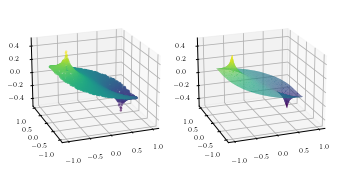

In [58]:
sns.set_context("paper", font_scale=0.75)
fig = plt.figure(figsize=(0.75*fig_width, 0.75*0.5*fig_width))
ax_solution = fig.add_subplot(1, 2, 1, projection="3d")
plotting.plot_graph_function_scatter(
    ax_solution, xy, sample["z"].to_numpy(), dist=dist, max_dist=0.1,
)
ax_solution.set_zlim(-0.5, 0.5)

z1 = ex_plot["label_locations"][0]
z2 = ex_plot["label_locations"][1]
analytic = compute_analytic_solution(xy, z1, z2)
ax_analytic = fig.add_subplot(1, 2, 2, projection="3d")
plotting.plot_graph_function_with_triangulation(
    ax_analytic, xy, analytic, dist=dist, max_dist=0.1,
)
ax_analytic.set_zlim(-0.5, 0.5)
# fig_results.suptitle(f"Discrete solution [n={n}] vs analytic solution")
fig.tight_layout()

if SAVE_PLOTS:
    fig.savefig(f"../plots/one_circle_demo.png", bbox_inches="tight", dpi=300)
    fig.savefig(f"../plots/one_circle_demo.pdf", bbox_inches="tight")

### Error for Dirac RHS

In [59]:
selected_experiments = {
    kernel: list(
        filter(
            lambda x: x["kernel"] == kernel
            and x["bump"] == "dirac"
            and "eps" in x
            and (
                x["n"] != 100000 or np.isclose(x["eps"], 0.02326135)
            ),  # Keep only eps = np.log(n) ** (1 / 15) * conn_radius
            experiments,
        )
    )
    for kernel in ["gaussian"]
}

n_error = sorted(list(set([e["n"] for e in list(selected_experiments.values())[0]])))
error = {kernel: {} for kernel in selected_experiments.keys()}
for kernel, experiments_with_kernel in selected_experiments.items():
    for n in n_error:
        ex = list(filter(lambda x: x["n"] == n, experiments_with_kernel))
        error[kernel][n] = {}
        error[kernel][n]["mean"] = np.mean([e["error_L1"] for e in ex])
        error[kernel][n]["max"] = np.max([e["error_L1"] for e in ex])
        error[kernel][n]["min"] = np.min([e["error_L1"] for e in ex])

/home/max/Dokumente/Studium/Masterarbeit/code/poisson_learning/examples/plotting.py:139: RuntimeWarning: overflow encountered in power
  return a * (X ** (-n))
2022-10-04 20:43:56 INFO:plotting   Fitted parameters: [0.11886249 0.1847028 ]


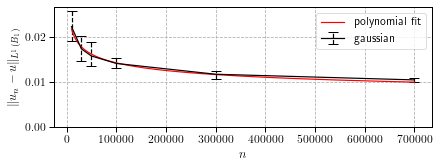

In [60]:
sns.set_context("paper", font_scale=4/3)

fig, ax = plt.subplots(1, 1, figsize=(fig_width, 0.4*fig_width))
plotting.error_plot(error, ax, fit="polynomial", c="black")
# ax_error.set_title(f"L1 Error compared with RHS {bump_width} to analytic solution")

ax.set_xlabel(r"$n$")
ax.set_ylabel(r"$\lVert u_n - u \rVert_{L^1 \left(B_1 \right)}$")
ax.legend()
ax.set_ylim(0.0, None)

fig.tight_layout()
if SAVE_PLOTS:
    fig.savefig(f"../plots/one_circle_dirac_n.pdf", bbox_inches="tight")

### Error for Dirac RHS with KNN graph

In [61]:
selected_experiments = {
    kernel: list(
        filter(
            lambda x: x["kernel"] == kernel
            and x["bump"] == "dirac"
            and "n_neighbors" in x,
            experiments,
        )
    )
    for kernel in ["gaussian"]
}

n_error = sorted(list(set([e["n"] for e in list(selected_experiments.values())[0]])))
error = {kernel: {} for kernel in selected_experiments.keys()}
for kernel, experiments_with_kernel in selected_experiments.items():
    for n in n_error:
        ex = list(filter(lambda x: x["n"] == n, experiments_with_kernel))
        if n == 100000:
            v = ex
        error[kernel][n] = {}
        error[kernel][n]["mean"] = np.mean([e["error_L1"] for e in ex])
        error[kernel][n]["max"] = np.max([e["error_L1"] for e in ex])
        error[kernel][n]["min"] = np.min([e["error_L1"] for e in ex])
        error[kernel][n]["size"] = len([e["error_L1"] for e in ex])

2022-10-04 20:44:08 INFO:plotting   Fitted parameters: [0.42688105 0.52734022]


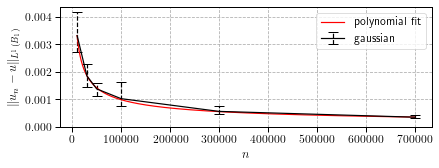

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, 0.4*fig_width))
plotting.error_plot(error, ax, fit="polynomial", c="black")
# ax_error.set_title(f"L1 Error compared with RHS {bump_width} to analytic solution")
ax.legend()
ax.set_xlabel(r"$n$")
ax.set_ylabel(r"$\lVert u_n - u \rVert_{L^1 \left(B_1 \right)}$")
ax.set_ylim(0.0, None)

fig.tight_layout()
if SAVE_PLOTS:
    fig.savefig(f"../plots/one_circle_dirac_n_knn.pdf", bbox_inches="tight")

### Convergence of bump RHS

In [67]:
selected_experiments = {
    f"bump={bump}": list(
        filter(lambda x:
            x["bump"] == bump
            and x["kernel"] == "gaussian"
            and "eps" in x,
            experiments,
        )
    )
    for bump in [0.02, 0.01, 0.1]
}

n_error = sorted(list(set([e["n"] for e in list(selected_experiments.values())[0]])))
error = {bump: {} for bump in selected_experiments.keys()}
for bump, experiments_with_bump in selected_experiments.items():
    for n in n_error:
        ex = list(filter(lambda x: x["n"] == n, experiments_with_bump))
        if ex:
            error[bump][n] = {}
            error_list = [e["error_L1_dirac"] for e in ex if e["error_L1_dirac"] > 0]
            error[bump][n]["mean"] = np.mean(error_list) if error_list else np.nan
            error[bump][n]["max"] = np.max(error_list) if error_list else np.nan
            error[bump][n]["min"] = np.min(error_list) if error_list else np.nan

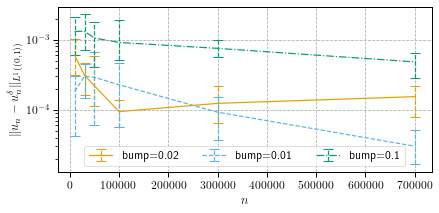

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, 0.5*fig_width))
ax.set_prop_cycle(plotting.line_cycler)

for i, (bump, e) in enumerate(error.items()):
    plotting.error_plot({bump: e}, ax, fit=None, label=bump)

    # ax.set_xscale("log")
    # ax.set_title("L1 error of solution with dirac RHS")
ax.legend(ncol=3, loc='lower center')
ax.set_yscale("log")
ax.set_xlabel(r"$n$")
ax.set_ylabel(r"$\lVert u_n - u_n^\delta \rVert_{L^1 \left((0, 1) \right)}$")

#ax.set_ylim(0, 2.5e-3)
fig.tight_layout()
if SAVE_PLOTS:
    fig.savefig(f"../plots/one_circle_dirac_bump_approximation.pdf", bbox_inches="tight")

### Convergence for different choices of epsilon

In [65]:
n = 100000
selected_experiments = {
    kernel: list(
        filter(
            lambda x: x["kernel"] == kernel
            and x["n"] == n
            and x["bump"] == "dirac"
            and "eps" in x,
            experiments,
        )
    )
    for kernel in ["gaussian"]
}
eps_error = list(set([e["eps"] for e in list(selected_experiments.values())[0]]))
eps_error = sorted(eps_error)
error = {kernel: {} for kernel in selected_experiments.keys()}
n_connected_component = {kernel: {} for kernel in selected_experiments.keys()}
for kernel, experiments_with_kernel in selected_experiments.items():
    for eps in eps_error:
        ex = list(filter(lambda x: np.isclose(x["eps"], eps), experiments_with_kernel))
        error[kernel][eps] = {}
        error[kernel][eps]["mean"] = np.mean([e["error_L1"] for e in ex])
        error[kernel][eps]["max"] = np.max([e["error_L1"] for e in ex])
        error[kernel][eps]["min"] = np.min([e["error_L1"] for e in ex])

        n_connected_component[kernel][eps] = {}
        n_connected_component[kernel][eps]["mean"] = np.mean([e["solution"].shape[0] for e in ex])
        n_connected_component[kernel][eps]["max"] = np.max([e["solution"].shape[0] for e in ex])
        n_connected_component[kernel][eps]["min"] = np.min([e["solution"].shape[0] for e in ex])

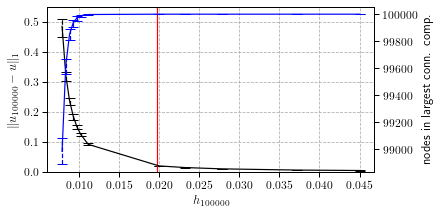

In [66]:
for kernel, e in error.items():
    fig, ax = plt.subplots(1, 1, figsize=(fig_width, 0.5*fig_width))
    plotting.error_plot({kernel: e}, ax, c="black")#, fit="polynomial")

    #ax.legend()
    ax.set_xlabel(fr"$h_{ {n} }$")
    ax.set_ylabel(fr"$\lVert u_{ {n} } - u \rVert_1$")

    # Draw connectivity radius
    conn_radius = np.log(n) ** (3 / 4) / np.sqrt(n)
    ax.vlines(conn_radius, 0.0, 1.0, color="red")
    ax.set_ylim(0.0, 0.55)
    #ax.set_xscale("log")

    ax_n = ax.twinx()
    plotting.error_plot({kernel: n_connected_component[kernel]}, ax_n, c="blue")#, fit="polynomial")
    ax_n.set_ylabel(r"nodes in largest conn. comp.")
    ax_n.grid(None)
    fig.tight_layout()
    if SAVE_PLOTS:
        fig.savefig(f"../plots/one_circle_convergence_eps.pdf", bbox_inches="tight")